# UMAP on tuning indices features

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


In [2]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

In [3]:
def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

## Load and preprocess data

In [4]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, 6))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, 6))
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)
            ti_rates = tuning_index(tc_rates)  # (neurons, num_cov)
            ti_FF = tuning_index(tc_FF)
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = ti_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = ti_rates.shape[0]
                
            features_rates = np.concatenate((features_rates, ti_rates), axis=0)
            features_FF = np.concatenate((features_FF, ti_FF), axis=0)

print(features_rates.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)
print(filter_hdc.shape)

(647, 6)
(647,)


In [5]:
def plot_umap_diff_mice(components, mice_sessions, num_hdc, num_nonhdc, plot_3d=False, title=None):
    num_neurons_per_mice = []
    for mouse_id in mice_sessions.keys():
        num = 0
        for session_id in mice_sessions[mouse_id]:
            num += num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id]
        num_neurons_per_mice.append(num)

    cum_neurons = np.cumsum(np.array(num_neurons_per_mice))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    colors = list(matplotlib.colors.BASE_COLORS)

    fig, ax = plt.subplots()
    for i, mouse_id in enumerate(mice_sessions.keys()):
            ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=mouse_id, alpha=0.4)
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i, mouse_id in enumerate(mice_sessions.keys()):
                ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=mouse_id, alpha=0.4)
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)        
        ax.legend()

In [6]:
def plot_umap_hdc_nonhdc(components, filter_hdc, plot_3d=False, title=None):
    fig, ax = plt.subplots()
    ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], alpha=0.4, c='r', label='hd neurons')
    ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], alpha=0.4, c='b', label='non-hd neurons')
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)   
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], components[filter_hdc, 2], 
                   alpha=0.4, c='r', label='hd neurons')
        ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], components[np.invert(filter_hdc), 2], 
                   alpha=0.4, c='b', label='non-hd neurons')
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)
        ax.legend()

## UMAP on rate tuning indices

(647, 2)


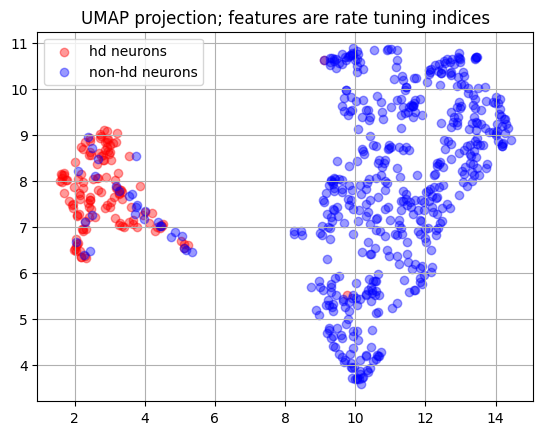

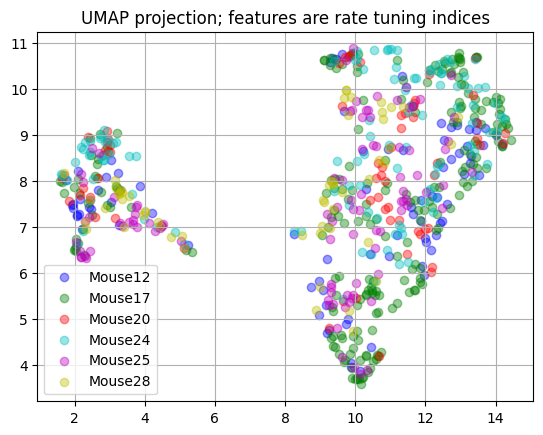

In [7]:
import umap

reducer = umap.UMAP(n_neighbors=20)
embedding_rates = reducer.fit_transform(features_rates)
print(embedding_rates.shape)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, title='UMAP projection; features are rate tuning indices')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, title='UMAP projection; features are rate tuning indices')

## UMAP on fano factor tuning indices

(647, 2)


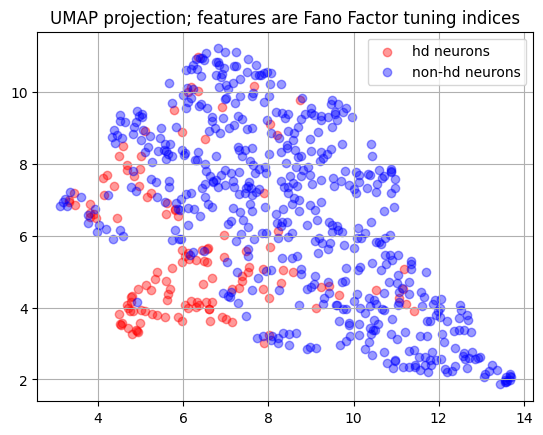

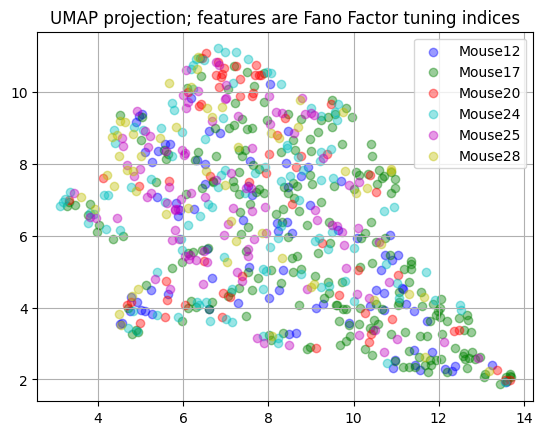

In [8]:
reducer2 = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_ff = reducer2.fit_transform(features_FF)
print(embedding_ff.shape)
plot_umap_hdc_nonhdc(embedding_ff, filter_hdc, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_diff_mice(embedding_ff, mice_sessions, num_hdc, num_nonhdc, title='UMAP projection; features are Fano Factor tuning indices')

## 3D UMAP on fano factor features

(647, 3)


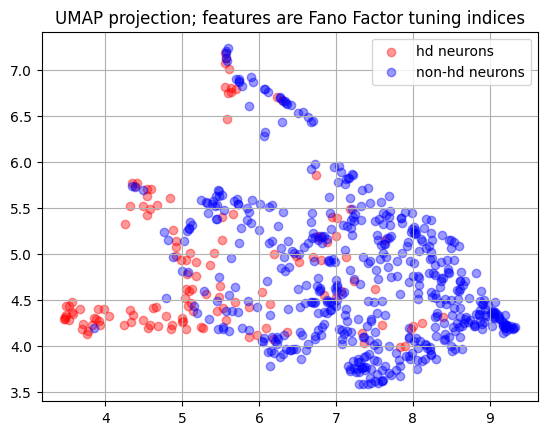

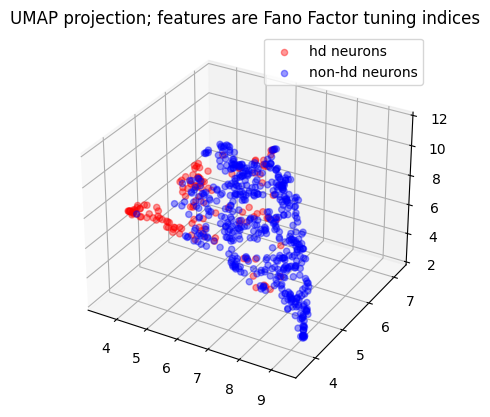

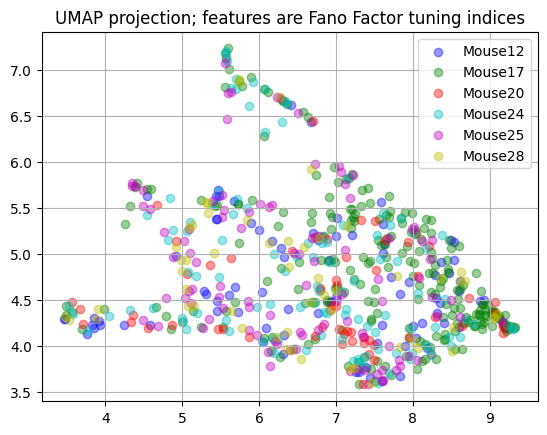

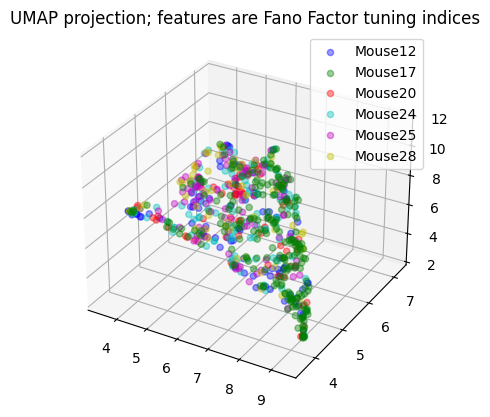

In [9]:
reducer3 = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
embedding_ff = reducer3.fit_transform(features_FF)
print(embedding_ff.shape)
plot_umap_hdc_nonhdc(embedding_ff, filter_hdc, plot_3d=True, title='UMAP projection; features are Fano Factor tuning indices')
plot_umap_diff_mice(embedding_ff, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are Fano Factor tuning indices')

## UMAP on the entire tuning curve

In [10]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _, _ = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
steps = data.shape[2]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features_rates = np.empty((0, steps))  # we have 6 covariates, so 6 features
features_FF = np.empty((0, steps))
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            tc_rates, tc_FF, tc_cov = load_tc_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
            
            # first covariate is head direction, take the entire tuning curve on head direction
            
            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = tc_rates.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = tc_rates.shape[0]
            
            features_rates = np.concatenate((features_rates, tc_rates[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
            features_FF = np.concatenate((features_FF, tc_FF[:,0,:].reshape((tc_rates.shape[0], tc_rates.shape[2]))), axis=0)
print(features_rates.shape)
print(num_hdc)
labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)

print(filter_hdc.shape)

(647, 100)
{'Mouse12': {'120806': 22}, 'Mouse17': {'130125': 2, '130128': 7, '130131': 7, '130202': 5, '130203': 7}, 'Mouse20': {'130514': 2, '130515': 4, '130516': 4, '130517': 6}, 'Mouse24': {'131213': 5, '131217': 11, '131218': 11}, 'Mouse25': {'140124': 10, '140128': 5, '140129': 11}, 'Mouse28': {'140310': 14}}
(647,)


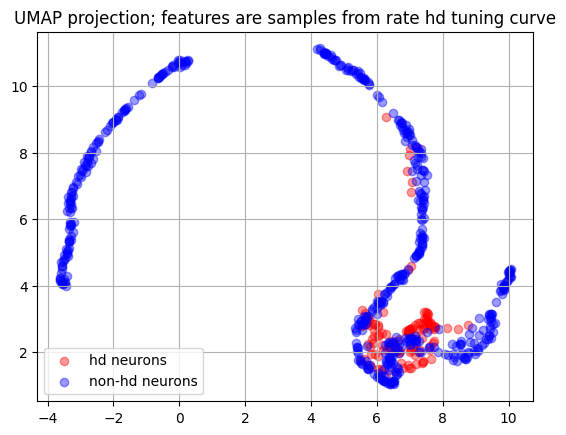

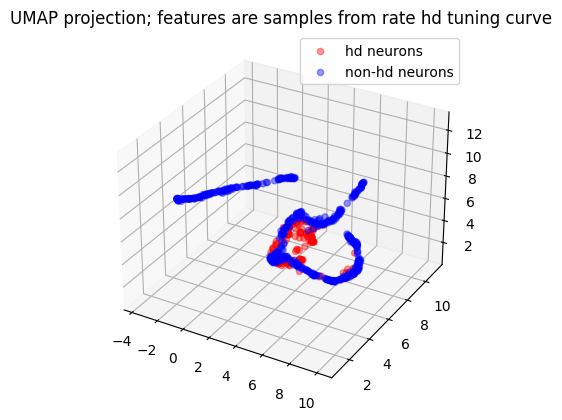

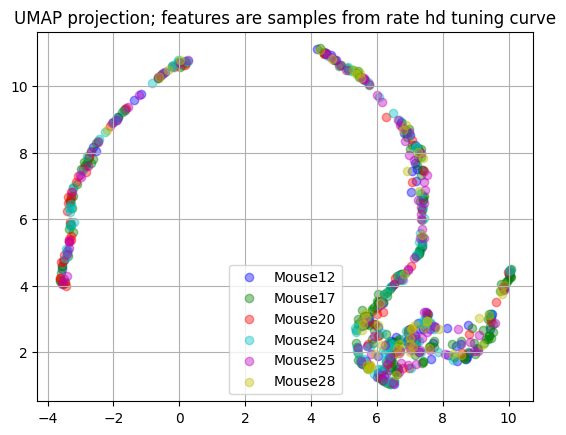

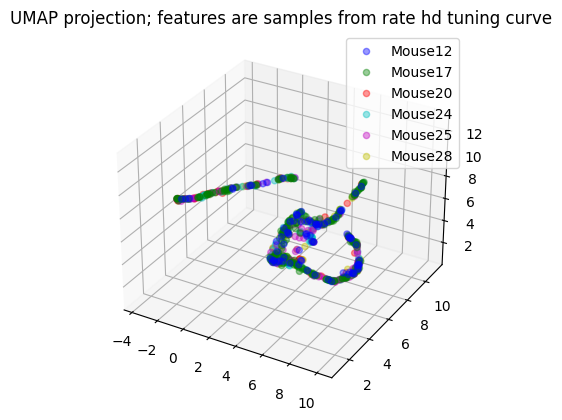

In [11]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.15 , n_components=3)
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')

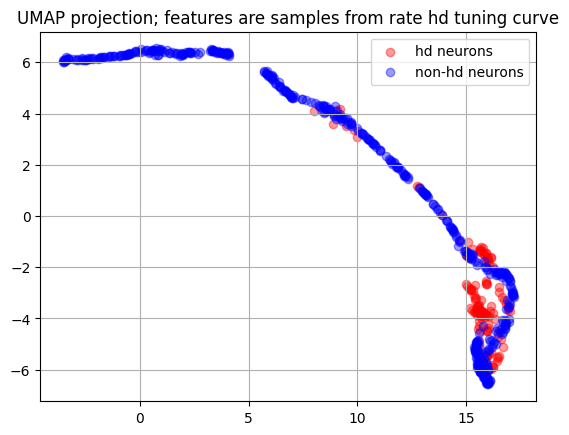

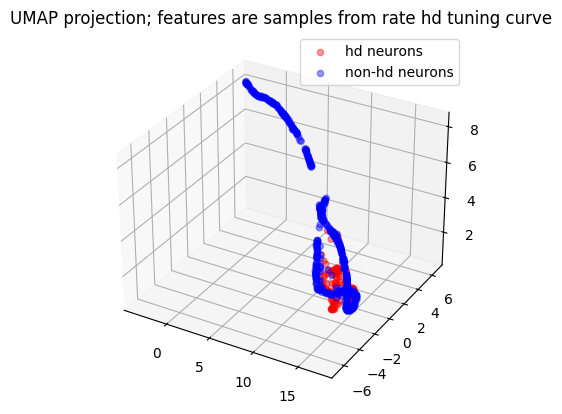

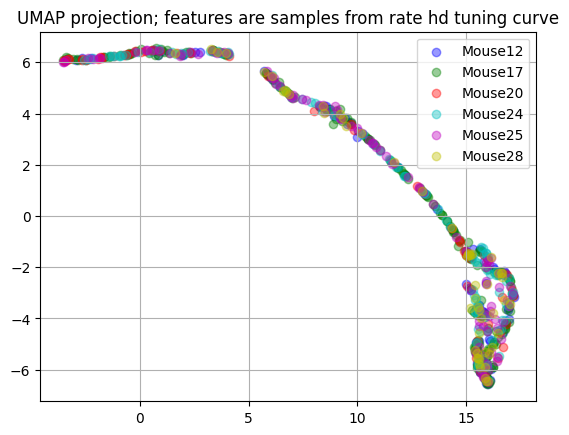

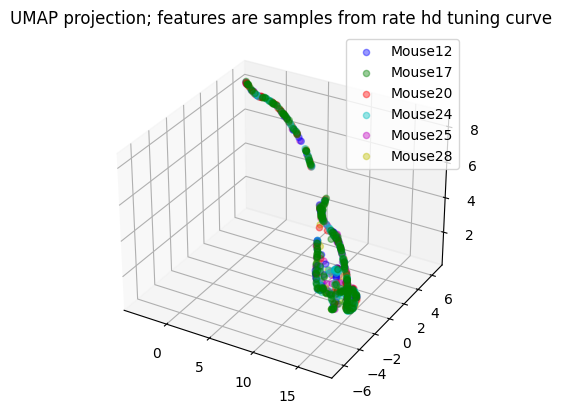

In [12]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.15 , n_components=3)
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from rate hd tuning curve')

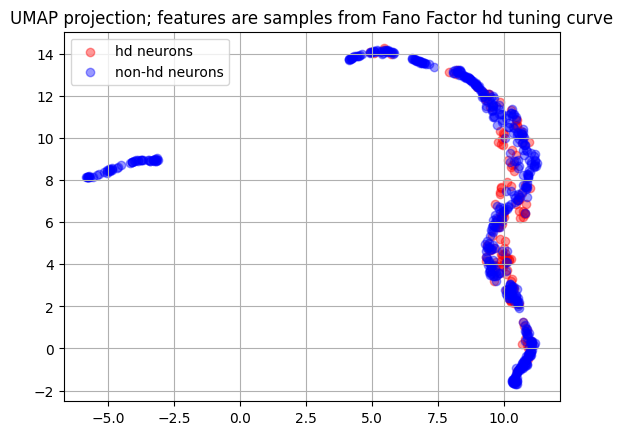

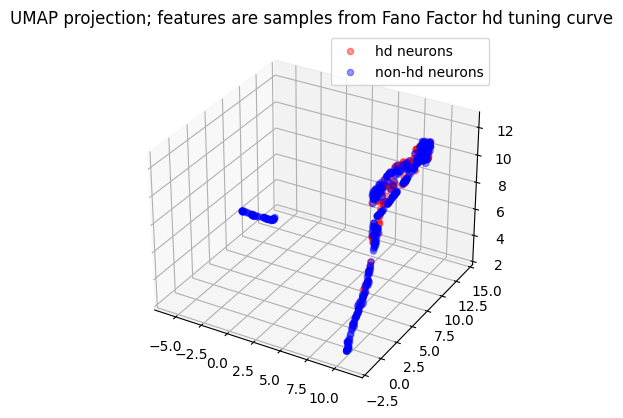

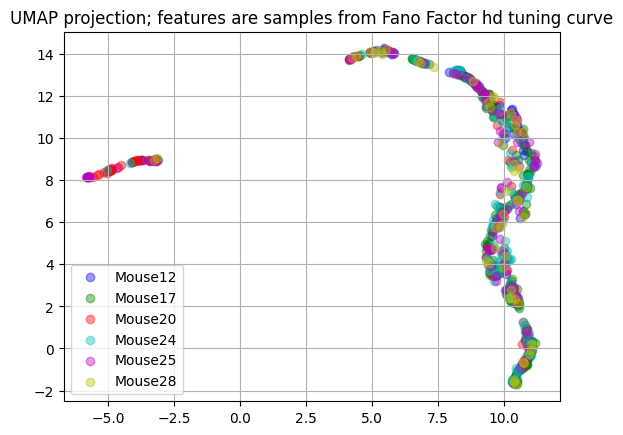

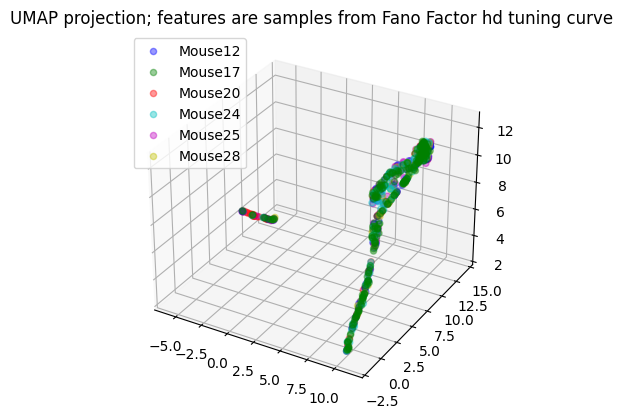

In [13]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3)
embedding_FF = reducer.fit_transform(features_FF)
plot_umap_hdc_nonhdc(embedding_FF, filter_hdc, plot_3d=True, title='UMAP projection; features are samples from Fano Factor hd tuning curve')
plot_umap_diff_mice(embedding_FF, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection; features are samples from Fano Factor hd tuning curve')

## UMAP with correlation metric

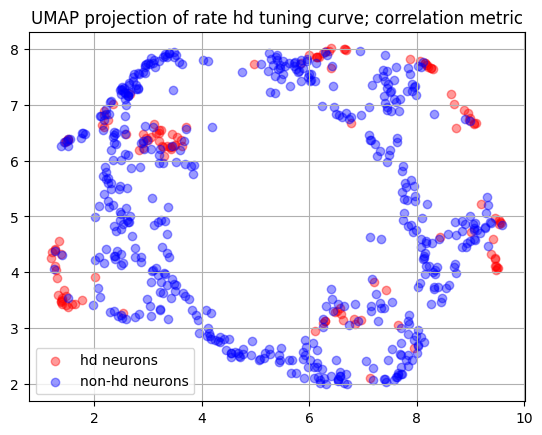

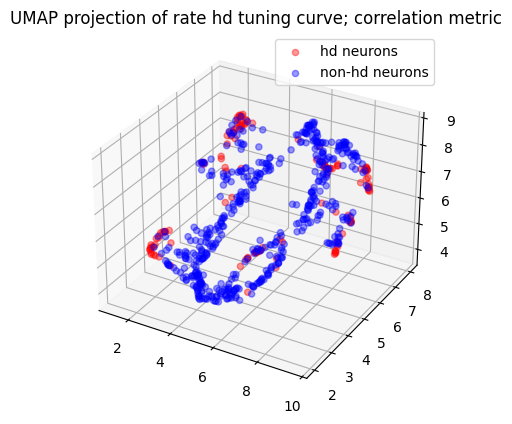

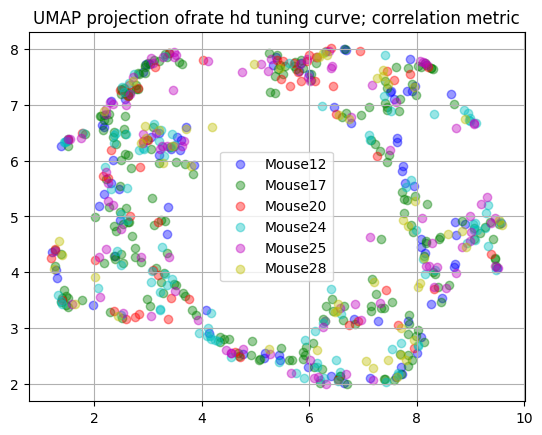

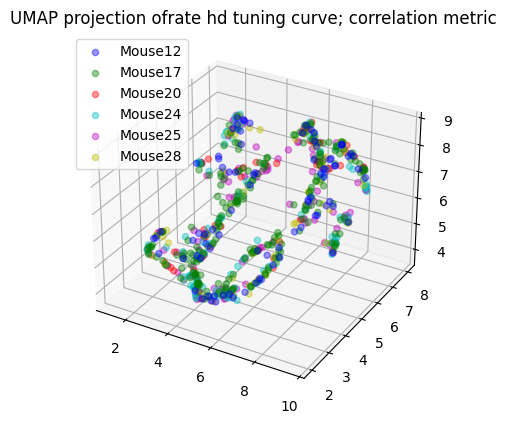

In [36]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1 , n_components=3, metric='correlation')
embedding_rates = reducer.fit_transform(features_rates)
plot_umap_hdc_nonhdc(embedding_rates, filter_hdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
plot_umap_diff_mice(embedding_rates, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection ofrate hd tuning curve; correlation metric')

<AxesSubplot: >

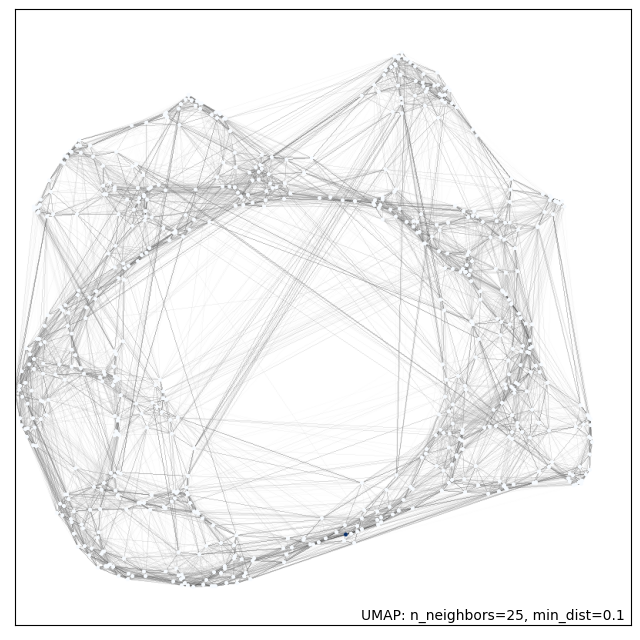

In [27]:
import umap.plot

reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='correlation').fit(features_rates)

umap.plot.connectivity(reducer, show_points=True)

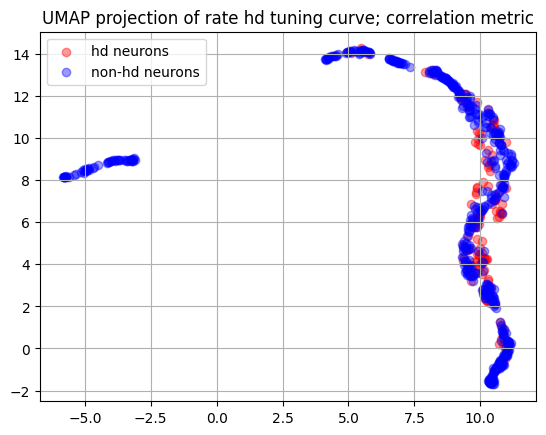

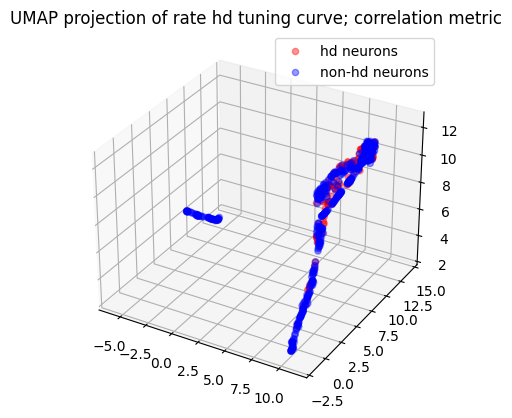

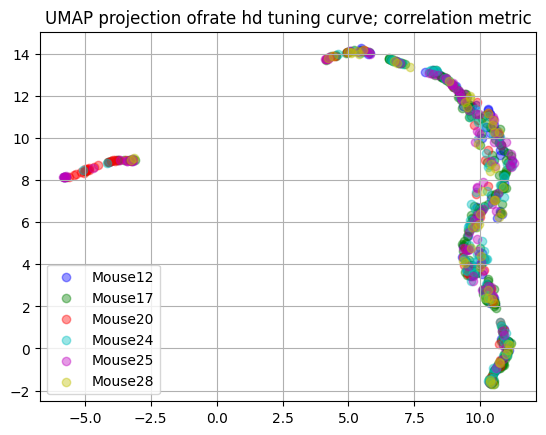

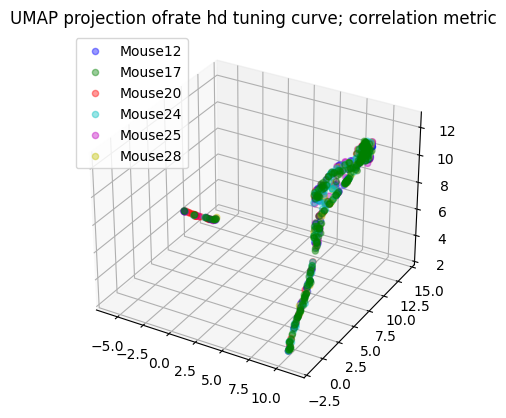

In [15]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1 , n_components=3, metric='correlation')
embedding_ff = reducer.fit_transform(features_FF)
plot_umap_hdc_nonhdc(embedding_FF, filter_hdc, plot_3d=True, title='UMAP projection of rate hd tuning curve; correlation metric')
plot_umap_diff_mice(embedding_FF, mice_sessions, num_hdc, num_nonhdc, plot_3d=True, title='UMAP projection ofrate hd tuning curve; correlation metric')